### 1. preparing the data

first step is prepare the library that will be needed

In [1]:
!pip install sastrawi


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 1.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.feature_extraction.text import TfidfVectorizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.metrics.pairwise import cosine_similarity

from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from keras import layers
from pathlib import Path

1. Preprocessing Data

read the dataset as dataframe pandas, and initiated object TfidfVectorizer, Stemmer, dan StopWordRemover

drop the unnecessary column, and calculate the average ranking based on the "place_id"

grouping that result as column into tourism_with_id, based on the "place_id"

In [4]:
# Inisialisasi objek TfidfVectorizer, Stemmer, dan StopWordRemover
tv = TfidfVectorizer(max_features=5000)
stem = StemmerFactory().create_stemmer()
stopword = StopWordRemoverFactory().create_stop_word_remover()

# Membaca data dari file CSV
data_tourism_rating = pd.read_csv('tourism_rating.csv')
data_tourism_with_id = pd.read_csv('tourism_with_id.csv')
data_user = pd.read_csv('user.csv')

# Menghapus kolom-kolom yang tidak diperlukan dari data_tourism_with_id
data_tourism_with_id.drop(['Rating','Time_Minutes','Coordinate','Lat','Long','Unnamed: 11','Unnamed: 12'],axis=1,inplace=True)

# Menghitung rata-rata peringkat berdasarkan 'Place_Id'
average_ratings = data_tourism_rating.groupby('Place_Id')['Place_Ratings'].mean().reset_index()

# Menggabungkan hasil perhitungan rata-rata dengan data_tourism_with_id berdasarkan 'Place_Id'
data_rekomendasi = pd.merge(average_ratings, data_tourism_with_id, on='Place_Id')


do the preprocessing function for cleaning the data using those library we import before. copy the csv into new dataframe and named it "data_content_based_filtering"

1.Using TF-IDF Vectorizer to convert text into vector representations.

2.Calculating the similarity between places using cosine similarity.

In [5]:
# Fungsi preprocessing untuk membersihkan dan memproses teks
def preprocessing(data):
    data = data.lower()
    data = stem.stem(data)
    data = stopword.remove(data)
    return data

# Copy data_rekomendasi ke data_content_based_filtering dan lakukan preprocessing
data_content_based_filtering = data_rekomendasi.copy()
data_content_based_filtering['Tags'] = data_content_based_filtering['Description'] + ' ' + data_content_based_filtering['Category']
data_content_based_filtering.drop(['Price','Place_Ratings','Description','Category','City'],axis=1,inplace=True)
data_content_based_filtering.Tags = data_content_based_filtering.Tags.apply(preprocessing)

# Ekstraksi fitur menggunakan TfidfVectorizer dan menghitung kemiripan cosine
vectors = tv.fit_transform(data_content_based_filtering.Tags).toarray()
similarity = cosine_similarity(vectors)


##1. Content based filtering part

Creating "recommend_by_content_based_filtering" function to provide place recommendations based on content similarity (content-based filtering).

1.proceed text (description and category) using Stemming and Stopword Removal.

2.Combining description and category to create a new column 'Tags'.




In [6]:

# Fungsi rekomendasi berdasarkan Content-Based Filtering
def recommend_by_content_based_filtering(nama_tempat):
    nama_tempat_index = data_content_based_filtering[data_content_based_filtering['Place_Name']==nama_tempat].index[0]
    distancess = similarity[nama_tempat_index]
    nama_tempat_list = sorted(list(enumerate(distancess)),key=lambda x: x[1],reverse=True)[1:10]

    recommended_nama_tempats = []
    for i in nama_tempat_list:
        recommended_nama_tempats.append([data_content_based_filtering.iloc[i[0]].Place_Name]+[i[1]])
        # print(nama_tempats.iloc[i[0]].original_title)

    return recommended_nama_tempats


##2. colaborative filtering

this step we proceed new data  

1. we merge the rating dataset (tourism_rating) into data_collaborative_filtering.

2. Encoding userID and placeID.
3. Mapping userID and placeID into the dataframe.
4. Determining the number of users and destinations (places).
5. Normalizing ratings using Min-Max Scaler.
6. Splitting the data into train and validation sets.

In [7]:

# Copy data_tourism_rating ke data_collaborative_filtering
data_collaborative_filtering = data_tourism_rating.copy()

# Mengubah userID menjadi list tanpa nilai yang sama
user_ids = data_collaborative_filtering['User_Id'].unique().tolist()
print('list userID: ', user_ids)

# Melakukan encoding userID
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded userID : ', user_to_user_encoded)

# Melakukan proses encoding angka ke userID
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke userID: ', user_encoded_to_user)

# Mengubah placeID menjadi list tanpa nilai yang sama
destination_ids = data_collaborative_filtering['Place_Id'].unique().tolist()

# Melakukan proses encoding placeID
destination_to_destination_encoded = {x: i for i, x in enumerate(destination_ids)}

# Melakukan proses encoding angka ke placeID
destination_encoded_to_destination = {i: x for i, x in enumerate(destination_ids)}

# Mapping userID ke dataframe user dan placeID ke dataframe destination
data_collaborative_filtering['user'] = data_collaborative_filtering['User_Id'].map(user_to_user_encoded)
data_collaborative_filtering['destination'] = data_collaborative_filtering['Place_Id'].map(destination_to_destination_encoded)

# Mendapatkan jumlah user dan destination
num_users = len(user_to_user_encoded)
print(num_users)
num_destinations = len(destination_encoded_to_destination)
print(num_destinations)

# Mengubah rating menjadi nilai float
data_collaborative_filtering['Place_Ratings'] = data_collaborative_filtering['Place_Ratings'].values.astype(np.float32)


list userID:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219

this step is for making the minimum and maximum rating from user,

we took the data from data_collaborative_filtering from before,
and last is we divide the data into 8:2

*(train data and validation data)*

In [8]:
# Nilai minimum dan maksimum rating
min_rating = min(data_collaborative_filtering['Place_Ratings'])
max_rating = max(data_collaborative_filtering['Place_Ratings'])

# Scaling nilai rating ke rentang [0, 1]
from sklearn.preprocessing import MinMaxScaler
x = data_collaborative_filtering[['user', 'destination']].values
ratings = data_collaborative_filtering['Place_Ratings'].values
scaler = MinMaxScaler()
y = scaler.fit_transform(ratings.reshape(-1, 1)).flatten()

# Membagi data menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * data_collaborative_filtering.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)


next step is we build the model, "RecommenderNet"

to present the user and destinations, we use embedding layers for it

we initiate the model before compile it, using num_user and num_destination from before

In [9]:

# Definisi model Collaborative Filtering menggunakan Neural Network
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_destinations, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_destinations = num_destinations
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.user_embedding_dropout = layers.Dropout(0.2)
        self.user_bias = layers.Embedding(num_users, 1)
        self.destination_embedding = layers.Embedding(
            num_destinations,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.destination_bias = layers.Embedding(num_destinations, 1)


    def call(self, inputs):
        user_vector = self.user_embedding_dropout(self.user_embedding(inputs[:, 0]))
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        destination_vector = self.destination_embedding(inputs[:, 1])
        destination_bias = self.destination_bias(inputs[:, 1])

        dot_user_destination = tf.tensordot(user_vector, destination_vector, 2)
        x = dot_user_destination + user_bias + destination_bias

        return tf.nn.sigmoid(x)

# Inisialisasi model Collaborative Filtering
model = RecommenderNet(num_users, num_destinations, 50)

# Kompilasi model dengan Binary Crossentropy loss dan Adam optimizer
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
# Pelatihan model
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=8,
    epochs=30,
    validation_data=(x_val, y_val),
    callbacks=callbacks
)


Epoch 1/30
1000/1000 [==============================] - 7s 4ms/step - loss: 0.6947 - root_mean_squared_error: 0.3438 - val_loss: 0.6929 - val_root_mean_squared_error: 0.3554
Epoch 2/30
1000/1000 [==============================] - 4s 4ms/step - loss: 0.6869 - root_mean_squared_error: 0.3380 - val_loss: 0.6930 - val_root_mean_squared_error: 0.3555
Epoch 3/30
1000/1000 [==============================] - 3s 3ms/step - loss: 0.6811 - root_mean_squared_error: 0.3338 - val_loss: 0.6933 - val_root_mean_squared_error: 0.3556
Epoch 4/30
1000/1000 [==============================] - 4s 4ms/step - loss: 0.6767 - root_mean_squared_error: 0.3305 - val_loss: 0.6936 - val_root_mean_squared_error: 0.3558


here we preproceed the data from data_tourism_with_id, data_tourism_rating
for sampling 'user_id', we randomly selecting from the rating data,
last step is
Rating Prediction using Collaborative Filtering Model

this line essentially simulates the process of recommending destinations for a randomly sampled user based on the collaborative filtering model's predictions. The recommendations are provided for destinations that the user has not visited, considering the user's historical preferences.

In [10]:

# Persiapan data untuk rekomendasi menggunakan Collaborative Filtering
destination_df = data_tourism_with_id
df = data_tourism_rating

# Mengambil sample user
user_id = df.User_Id.sample(1).iloc[0]
destination_visited_by_user = df[df.User_Id == user_id]

destination_not_visited = destination_df[~destination_df['Place_Id'].isin(destination_visited_by_user.Place_Id.values)]['Place_Id']
destination_not_visited = list(
    set(destination_not_visited)
    .intersection(set(destination_to_destination_encoded.keys()))
)

destination_not_visited = [[destination_to_destination_encoded.get(x)] for x in destination_not_visited]
user_encoder = user_to_user_encoded.get(user_id)
user_destination_array = np.hstack(
    ([[user_encoder]] * len(destination_not_visited), destination_not_visited)
)

# Prediksi rating menggunakan model Collaborative Filtering
ratings = model.predict(user_destination_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_destination_ids = [
    destination_encoded_to_destination.get(destination_not_visited[x][0]) for x in top_ratings_indices
]


13/13 [==============================] - 0s 2ms/step


This code is designed to display recommendations for a specific user based on the collaborative filtering model.  selects the top 5 destinations that have received the highest ratings from the user based on the Place_Ratings column. This loop iterates through the selected destinations (destination_df_rows) and prints their names.

In summary, this code provides a clear output of destination recommendations for a specific user. It displays destinations with high ratings from the user and the top 10 recommendations from the collaborative filtering model.








In [11]:
# Menampilkan rekomendasi untuk pengguna tertentu
print('Showing recommendations for users: {}'.format(user_id))

# Menampilkan pemisah untuk kejelasan tampilan
print('===' * 9)

# Menampilkan destinasi dengan peringkat tinggi dari pengguna
print('Destination with high ratings from user')
print('----' * 8)

# Mengambil top 5 destinasi yang mendapatkan peringkat tertinggi dari pengguna
top_destination_user = (
    destination_visited_by_user.sort_values(
        by='Place_Ratings',
        ascending=False
    )
    .head(5)
    .Place_Id.values
)

# Menampilkan nama destinasi dengan peringkat tinggi
destination_df_rows = destination_df[destination_df['Place_Id'].isin(top_destination_user)]
for row in destination_df_rows.itertuples():
    print(row.Place_Name)

# Menampilkan pemisah untuk kejelasan tampilan
print('----' * 8)

# Menampilkan top 10 rekomendasi destinasi
print('Top 10 destination recommendations')
print('----' * 8)

# Mengambil destinasi yang direkomendasikan
recommended_destination = destination_df[destination_df['Place_Id'].isin(recommended_destination_ids)]
for row in recommended_destination.itertuples():
    print(row.Place_Name)

Showing recommendations for users: 236
Destination with high ratings from user
--------------------------------
Museum Fatahillah
Taman Agrowisata Cilangkap
Geoforest Watu Payung Turunan
Dusun Bambu
Bumi Perkemahan Batu Kuda
--------------------------------
Top 10 destination recommendations
--------------------------------
Pantai Baron
Tafso Barn
Glamping Lakeside Rancabali
Bukit Jamur
Kota Mini
Taman Keputran
Taman Ekspresi Dan Perpustakaan
Masjid Nasional Al-Akbar
Keraton Surabaya
Taman Hiburan Rakyat


this line is example of use content based filtering we build before, seek for the nearest places from the input

In [12]:
recommend_by_content_based_filtering('Kidzania')

[['Water Park Bandung Indah', 0.14466239131457276],
 ['Waduk Jatibarang', 0.12778025688845085],
 ['Dunia Fantasi', 0.11367806849784222],
 ['Taman Barunawati', 0.11203497424603112],
 ['Panghegar Waterboom Bandung', 0.10342293209555639],
 ['Taman Pelangi', 0.0992145844765313],
 ['Peta Park', 0.08832579793528267],
 ['Taman Pintar Yogyakarta', 0.08710597733039227],
 ['Taman Lansia', 0.08692961554338768]]

to visualize how well machine learning model is learning from the training data over epochs. It provides insights into the training process and helps you assess whether your model is converging and learning the patterns in the data.

Training Loss (Train): The loss on the training data during each epoch. You want this to decrease over epochs, indicating that the model is learning from the training data.

Validation Loss (Validation): The loss on a separate validation dataset during each epoch. This dataset is not used for training but is used to evaluate the model's generalization to unseen data. You want this to decrease as well, but if it starts increasing while the training loss is still decreasing, it might indicate overfitting.




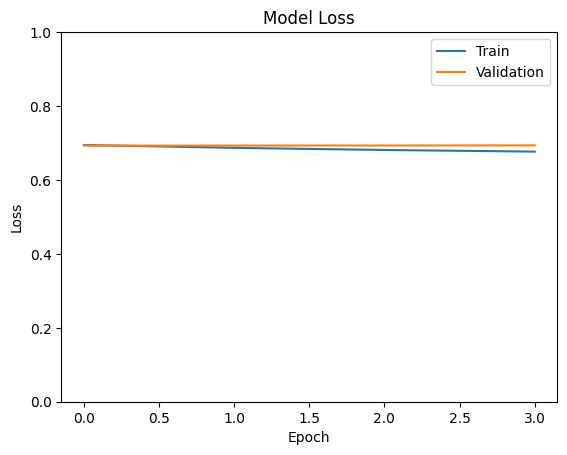

In [13]:
# Assuming 'history' is the object returned by model.fit

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Set the y-axis range from 0 to 1
plt.ylim(0, 1)

plt.show()

this line is for saving few file tha for another source in this project

Save the trained neural network model to an HDF5 file (embedding_model.h5).
Save the test data to a pickle file (test_data.pkl).

convert model into tflite

In [16]:
import pickle

# Save the model to an H5 file
model.save('collaborative_filtering_model', save_format='tf')
model.save_weights('collaborative_filtering_weights.h5')
# Save the necessary data to a pickle file
data_to_pickle = {
    'user_to_user_encoded': user_to_user_encoded,
    'destination_to_destination_encoded': destination_to_destination_encoded,
    'scaler': scaler
}

with open('collaborative_filtering_data.pkl', 'wb') as file:
    pickle.dump(data_to_pickle, file)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
tflite_model
with open('model.tflite', 'wb') as model_:
  model_.write(tflite_model)